# Step 1

In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sentence_transformers import SentenceTransformer
import re

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


lyrics_df = pd.read_csv('../dataset/scraped_lyrics.csv')


def clean_text(text):
    
    text = text.lower()
  
    text = re.sub(r'[^a-z0-9\s]', '', text)
   
    text = re.sub(r'\s+', ' ', text)
    
    text = text.strip()
    return text

lyrics_df['Cleaned Lyrics'] = lyrics_df['Lyrics'].astype(str).apply(clean_text)


lyrics_df = lyrics_df[lyrics_df['Cleaned Lyrics'].str.len() > 20]


lyrics_df = lyrics_df.reset_index(drop=True)


sbert_model = SentenceTransformer('all-mpnet-base-v2', device=device)


print("Generating embeddings with SBERT...")
lyrics = lyrics_df['Cleaned Lyrics'].tolist()
embeddings = sbert_model.encode(lyrics, convert_to_numpy=True, show_progress_bar=True)


np.save('../embedding/lyrics_embeddings.npy', embeddings)
lyrics_df.to_csv('../dataset/filtered_lyrics.csv', index=False)
print("Embeddings and filtered lyrics saved successfully.")


class LyricDataset(Dataset):
    def __init__(self, embeddings):
        self.embeddings = embeddings

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        embedding = self.embeddings[idx]
        
        noisy_embedding = embedding + np.random.normal(0, 0.1, embedding.shape)
        return torch.tensor(noisy_embedding, dtype=torch.float32), torch.tensor(embedding, dtype=torch.float32)

dataset = LyricDataset(embeddings)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

class NoiseReductionAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2):
        super(NoiseReductionAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim2, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, input_dim)
        )

    def forward(self, x):
        latent_representation = self.encoder(x)
        reconstructed_embedding = self.decoder(latent_representation)
        return reconstructed_embedding

embedding_size = embeddings.shape[1]
latent_dim1 = 512
latent_dim2 = 256

model = NoiseReductionAutoencoder(embedding_size, latent_dim1, latent_dim2).to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for noisy_embedding, clean_embedding in dataloader:
        noisy_embedding = noisy_embedding.to(device)
        clean_embedding = clean_embedding.to(device)
        optimizer.zero_grad()
        reconstructed_embedding = model(noisy_embedding)
        loss = loss_function(reconstructed_embedding, clean_embedding)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}')


torch.save(model.state_dict(), '../embedding/autoencoder.pth')
print("Autoencoder model saved successfully.")


model.eval()
with torch.no_grad():
    embeddings_tensor = torch.tensor(embeddings, dtype=torch.float32).to(device)
    enhanced_embeddings = model.encoder(embeddings_tensor).cpu().numpy()

np.save('../embedding/enhanced_embeddings.npy', enhanced_embeddings)
print("Enhanced embeddings saved successfully.")


c:\Users\ramel\Desktop\INSPER\24.2\NLP\APS_EMBEDDING\APS_EMBEDDING_NLP\.venv\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


Using device: cuda
Generating embeddings with SBERT...


Batches: 100%|██████████| 991/991 [37:47<00:00,  2.29s/it]


Embeddings and filtered lyrics saved successfully.
Epoch [1/10], Loss: 0.0006
Epoch [2/10], Loss: 0.0006
Epoch [3/10], Loss: 0.0005
Epoch [4/10], Loss: 0.0005
Epoch [5/10], Loss: 0.0005
Epoch [6/10], Loss: 0.0005
Epoch [7/10], Loss: 0.0005
Epoch [8/10], Loss: 0.0005
Epoch [9/10], Loss: 0.0005
Epoch [10/10], Loss: 0.0005
Autoencoder model saved successfully.
Enhanced embeddings saved successfully.


In [2]:

torch.save(model.state_dict(), 'autoencoder.pth')


# Step 2

Using device: cuda
Número de categorias únicas em 'Lyrics': 19697
Número de categorias após agrupamento: 11


) missing from font(s) DejaVu Sans.pykernel_11972\1070753047.py:55: UserWarning: Glyph 13 (
  plt.tight_layout()
C:\Users\ramel\AppData\Local\Temp\ipykernel_11972\1070753047.py:55: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ramel\AppData\Local\Temp\ipykernel_11972\1070753047.py:55: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
) missing from font(s) DejaVu Sans.NLP\APS_EMBEDDING\APS_EMBEDDING_NLP\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ramel\Desktop\INSPER\24.2\NLP\APS_EMBEDDING\APS_EMBEDDING_NLP\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


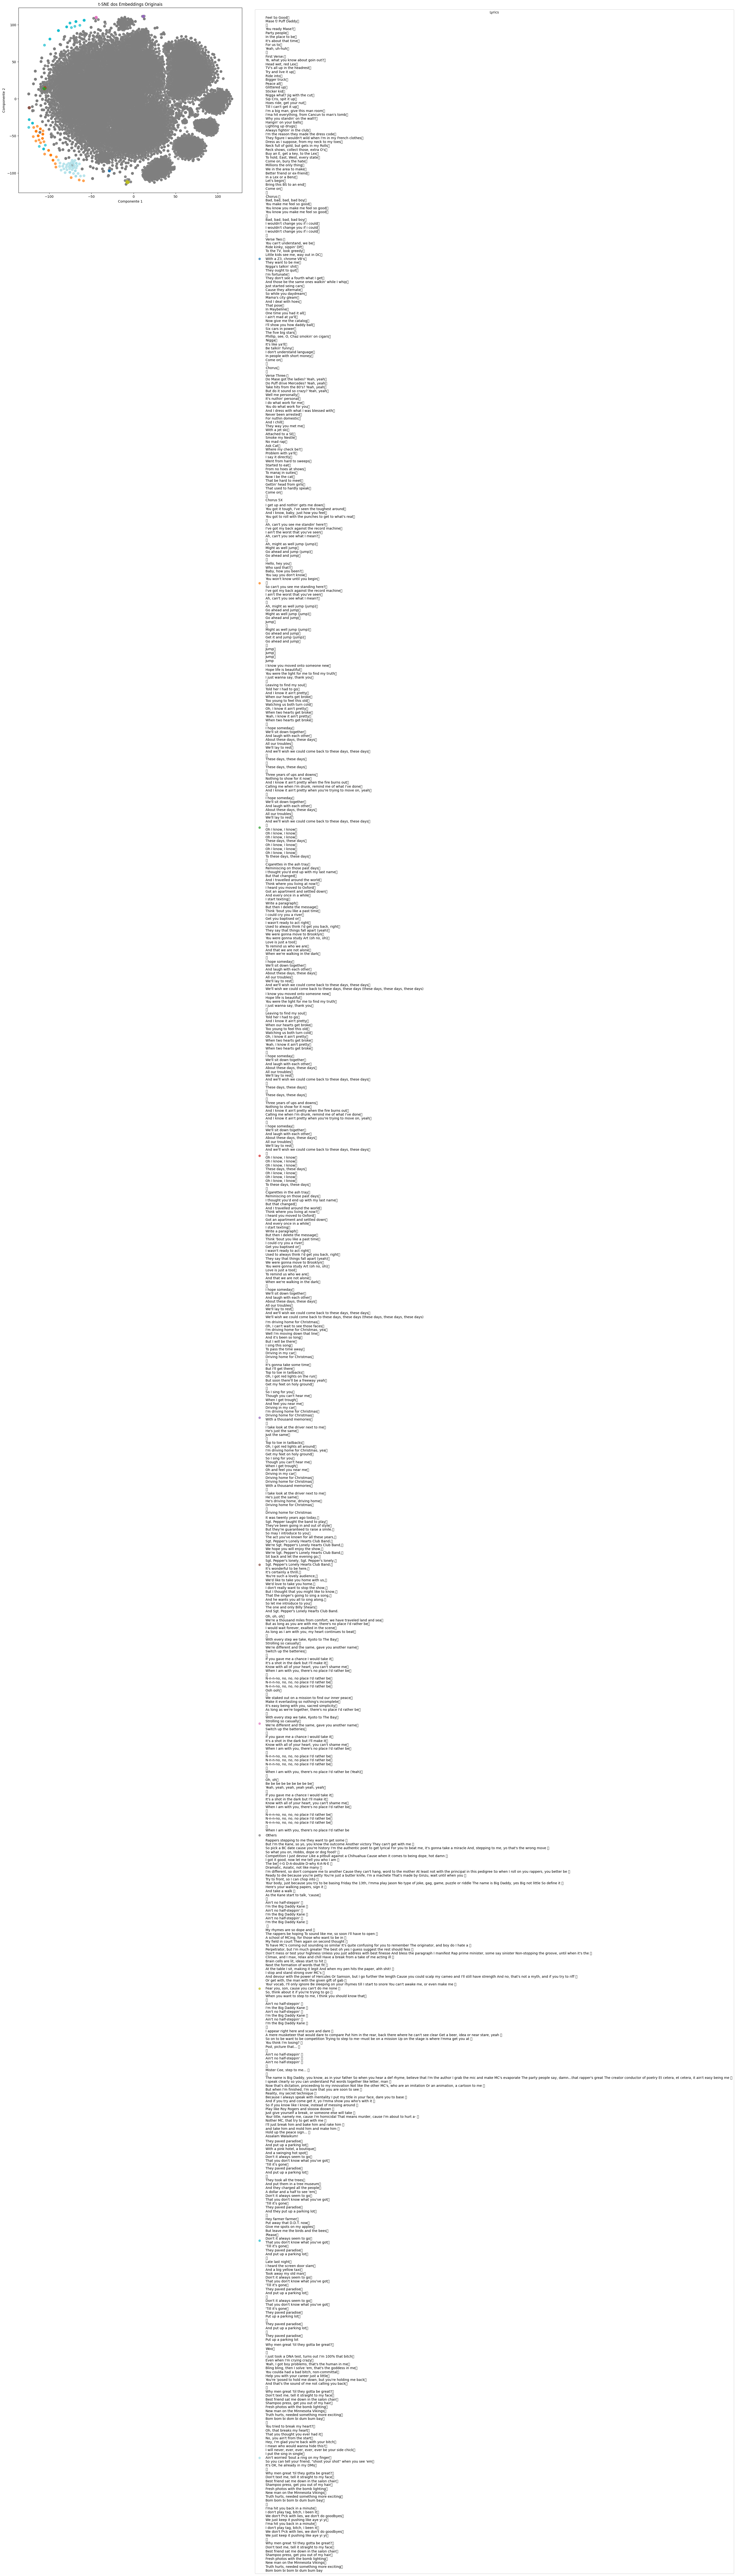

) missing from font(s) DejaVu Sans.pykernel_11972\1070753047.py:55: UserWarning: Glyph 13 (
  plt.tight_layout()
C:\Users\ramel\AppData\Local\Temp\ipykernel_11972\1070753047.py:55: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ramel\AppData\Local\Temp\ipykernel_11972\1070753047.py:55: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
) missing from font(s) DejaVu Sans.NLP\APS_EMBEDDING\APS_EMBEDDING_NLP\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ramel\Desktop\INSPER\24.2\NLP\APS_EMBEDDING\APS_EMBEDDING_NLP\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


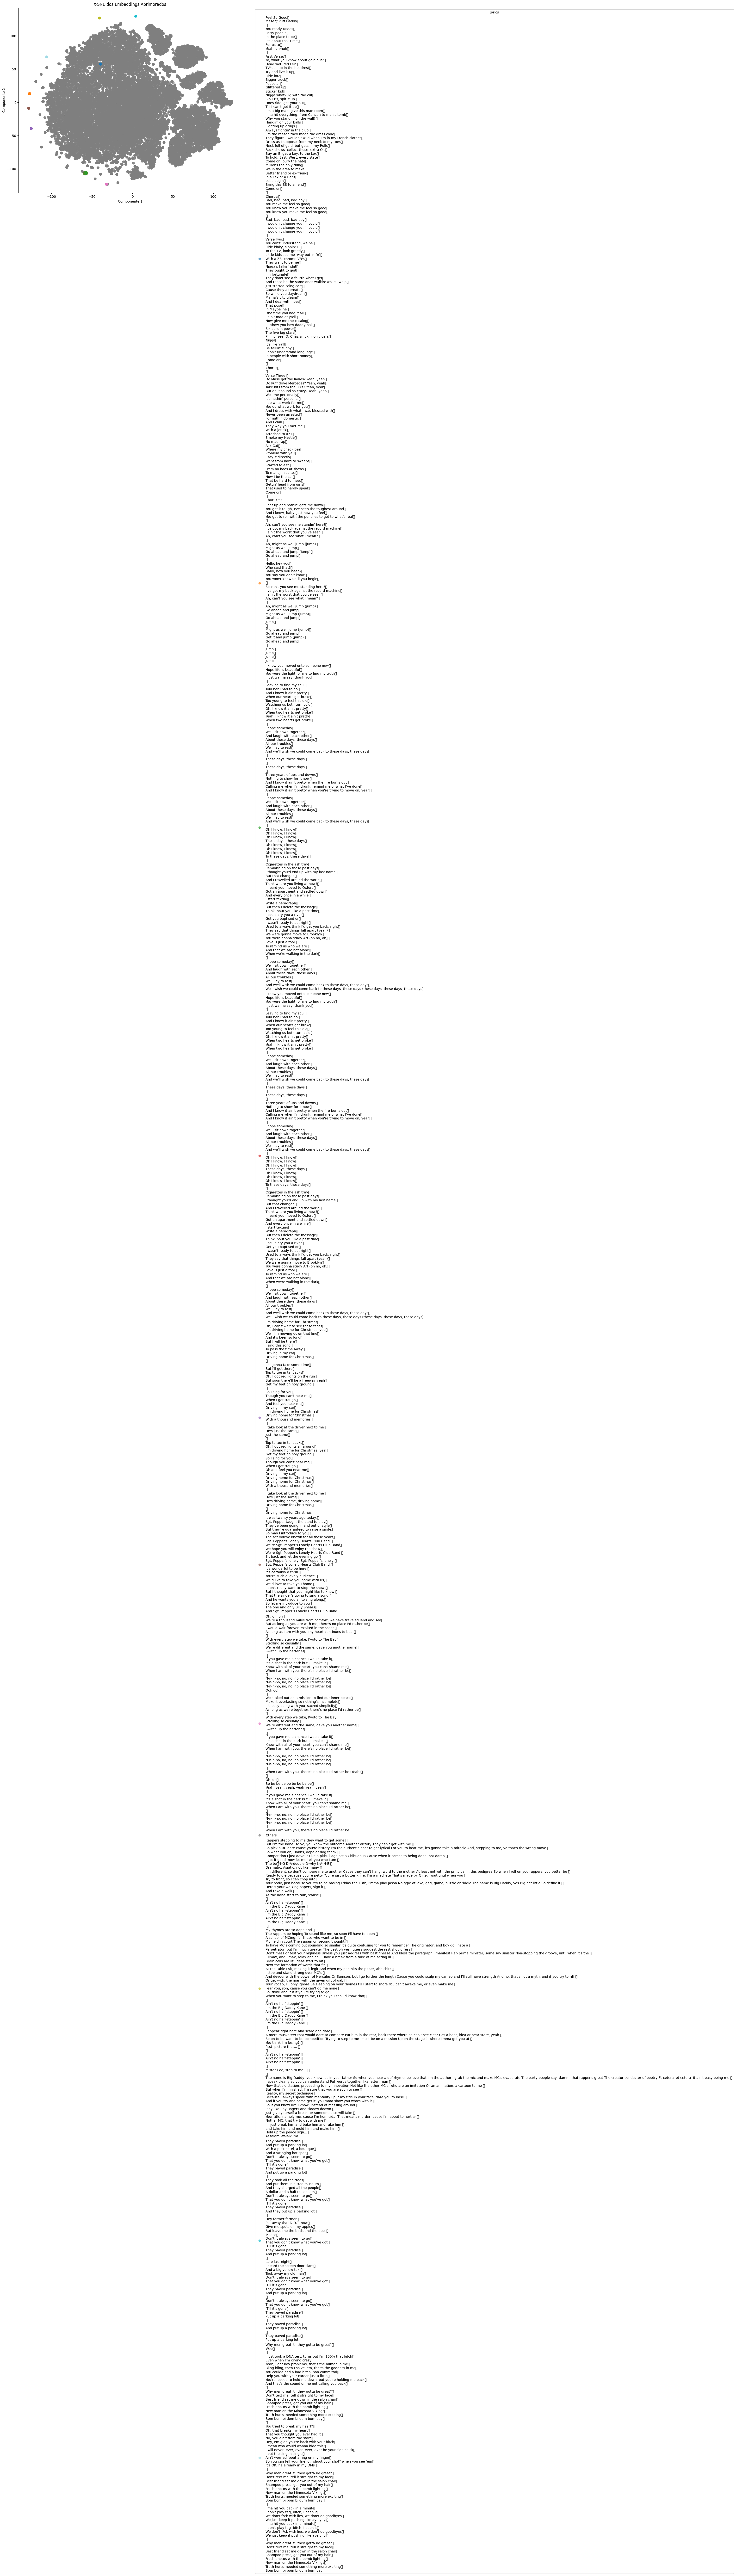

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

original_vectors = embeddings  
advanced_vectors = np.load('../embedding/enhanced_embeddings.npy')

reducer_pretrained = TSNE(n_components=2, perplexity=30, random_state=42)
reduced_pretrained = reducer_pretrained.fit_transform(original_vectors)

reducer_enhanced = TSNE(n_components=2, perplexity=30, random_state=42)
reduced_enhanced = reducer_enhanced.fit_transform(advanced_vectors)

lyrics_df = pd.read_csv('../dataset/filtered_lyrics.csv')

category = 'Lyrics'  

num_unique_categories = lyrics_df[category].nunique()
print(f"Número de categorias únicas em '{category}': {num_unique_categories}")


N = 10  
top_categories = lyrics_df[category].value_counts().nlargest(N).index.tolist()

lyrics_df['Category_Plot'] = lyrics_df[category].apply(lambda x: x if x in top_categories else 'Others')

labels = lyrics_df['Category_Plot'].tolist()


from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_ids = label_encoder.fit_transform(labels)
num_classes = len(np.unique(label_ids))
print(f"Número de categorias após agrupamento: {num_classes}")


import matplotlib.cm as cm
import matplotlib.colors as mcolors
cmap = plt.get_cmap('tab20', num_classes)

def visualize_projections(projections, title, label_ids, labels):
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(projections[:, 0], projections[:, 1], c=label_ids, cmap=cmap, alpha=0.7, s=50)
    plt.title(title)
    plt.xlabel('Componente 1')
    plt.ylabel('Componente 2')
    handles, _ = scatter.legend_elements(num=num_classes)
    legend_labels = label_encoder.inverse_transform(np.unique(label_ids))
    plt.legend(handles, legend_labels, title=category, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()


visualize_projections(reduced_pretrained, 't-SNE dos Embeddings Originais', label_ids, labels)


visualize_projections(reduced_enhanced, 't-SNE dos Embeddings Aprimorados', label_ids, labels)


# Step 3

In [ ]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import re
import os
import tqdm


def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text) 
    text = re.sub(r'\s+', ' ', text)        
    text = text.strip()
    return text


df = pd.read_csv('../dataset/filtered_lyrics.csv')


if 'Cleaned Lyrics' in df.columns:
    lyrics_list = df['Cleaned Lyrics'].tolist()
else:
    df['Cleaned Lyrics'] = df['Lyrics'].apply(clean_text)
    lyrics_list = df['Cleaned Lyrics'].tolist()


embeddings_file = '../embedding/lyrics_embeddings.npy'

if os.path.exists(embeddings_file):
    embeddings = np.load(embeddings_file)
    print("Loaded embeddings from file.")
else:
    sbert_model = SentenceTransformer('all-mpnet-base-v2')
    embeddings = sbert_model.encode(lyrics_list, convert_to_numpy=True, show_progress_bar=True)
    np.save(embeddings_file, embeddings)
    print("Generated and saved embeddings.")


sbert_model = SentenceTransformer('all-mpnet-base-v2')


def get_query_embedding(query):
    query = clean_text(query)
    return sbert_model.encode(query, convert_to_numpy=True)


def search(query, top_k=10):
    query_embedding = get_query_embedding(query)
    similarities = cosine_similarity([query_embedding], embeddings)[0]
  
    sorted_indices = similarities.argsort()[::-1]
    results = []
    titles = set()
    for idx in sorted_indices:
        title = df.iloc[idx]['Song Name']
        if title not in titles:
            results.append({
                'Song Name': title,
                'Similarity': similarities[idx],
                'Lyrics': df.iloc[idx]['Lyrics']
            })
            titles.add(title)
        if len(results) == top_k:
            break
    return pd.DataFrame(results)


query1 = "love and heartbreak"
results1 = search(query1, top_k=10)
print("Test Results with SBERT, Using Filtered Lyrics:")
print(results1[['Song Name', 'Similarity']])


cuda
Test Results with SBERT, Language Filtering, and Preprocessing:
                        Song Name  Similarity
0                        The Rose    0.593315
1                 With Or Without    0.581248
2                    Get Together    0.580406
3  What Is This Thing Called Love    0.575974
4             Hands Off the Wheel    0.570333
5         Love Will Tear Us Apart    0.560208
6                          MMMBop    0.550839
7             Something About You    0.549870
8                 It Would Be You    0.532923
9                   Brand New Day    0.532534


In [ ]:

query2 = "antidisestablishmentarianism"
results2 = search(query2, top_k=10)

threshold = 0.5
filtered_results2 = results2[results2['Similarity'] >= threshold]
print("\nTest 2 Results:")
print(filtered_results2[['Song Name', 'Similarity']])



Test 2 Results:
                            Song Name  Similarity
0  Supercalifragilisticexpialidocious    0.511443


In [ ]:

query3 = "time travel paradox"
results3 = search(query3, top_k=10)
print("\nTest 3 Results:")
print(results3[['Song Name', 'Similarity']])



Test 3 Results:
                          Song Name  Similarity
0               Tribute to the Past    0.468967
1  Spending Time [Multimedia Track]    0.422412
2          Where Do We Go From Here    0.396293
3                     Another Space    0.395179
4                     Absolute Zero    0.385202
5                  Time in a Bottle    0.372783
6              Time Travel in Texas    0.359476
7                Invisible Horizons    0.350368
8                        Golden Age    0.349256
9            Mother Shipton's Words    0.345966
